# The Curse of Unrolling

Given an implicit function defined based on the solution to a (quadratic convex) optimization problem

$$
q(\theta) =
\left \{
\text{solve}
\;
\arg \min_x
f(x, \theta)
\right \}
=: x^*
$$

with

$$
f(x, \theta) = \frac{1}{2} \theta x^2 - bx \qquad \theta, x \in \mathbb{R}
$$

and its approximation by gradient descent

$$
\tilde{q}(\theta;x^{[0]}, \eta, T)
=
\left \{
x^{[T]}=\phi^T(x^{[0]})
\;
\text{with}
\;
\phi(x^{[t]})=x^{[t]}- \eta\frac{\partial f}{\partial x}\bigg|_{x=x^{[t]}, \theta}
\right \} = x^{[T]}
$$

how does the **Jacobian suboptimality** converge based on the number of iterations taken in the gradient descent approximation

$$
\left| \left|
\frac{\partial x^{[t]}}{\partial \theta}
-
\frac{\partial x^*}{\partial \theta}
\right| \right|_F
$$

This notebook is based on the paper "The Curse of Unrolling: Rate of Differentiating through Optimization" by Scieur et al. (2022): [https://arxiv.org/abs/2209.13271](https://arxiv.org/abs/2209.13271)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
plt.style.use("dark_background")

In [3]:
B_VALUE = 0.0

In [4]:
def inner_objective(x, theta):
    return 0.5 * theta * x**2 - B_VALUE * x

In [5]:
def inner_objective_arg_optimum(theta):
    return B_VALUE / theta

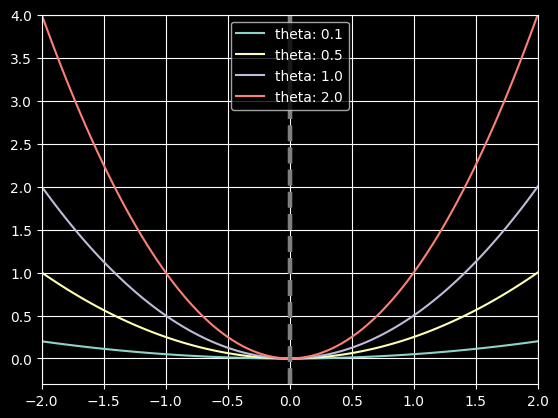

In [6]:
x_range = jnp.linspace(-2, 2, 100)
for theta in [0.1, 0.5, 1.0, 2.0]:
    inner_objective_values = inner_objective(x_range, theta)
    plt.plot(x_range, inner_objective_values, label="theta: " + str(theta))
    plt.vlines(inner_objective_arg_optimum(theta), -0.3, 4.0, color="grey", linewidth=3, linestyles="dashed")
plt.grid()
plt.xlim(-2.0, 2.0)
plt.ylim(-0.3, 4.0)
plt.legend()

In [7]:
def gd_step(x_prev, theta, learning_rate):
    x_next = x_prev - learning_rate * jax.grad(inner_objective, argnums=0)(x_prev, theta)
    return x_next

def optimize_gd(theta, init=0.5, learning_rate=0.1, num_iter=1000):
    """
    Performs optimization via gradient descent and returns the full history of
    iterates.
    """
    def scan_fn(x_prev, _):
        x_next = gd_step(x_prev, theta, learning_rate)
        return x_next, x_next
    
    _, x_history = jax.lax.scan(scan_fn, init, None, length=num_iter)

    x_history_with_init = jnp.concatenate([jnp.array([init]), x_history])

    return x_history_with_init

In [8]:
THETA = 0.05

In [9]:
gd_iterates = optimize_gd(THETA)

In [10]:
gd_iterates

Array([0.5       , 0.4975    , 0.4950125 , ..., 0.00336051, 0.00334371,
       0.00332699], dtype=float32)

In [11]:
gd_iterates.shape

(1001,)

In [12]:
solution_suboptimality = jnp.abs(gd_iterates - inner_objective_arg_optimum(THETA))
loss_suboptimality = jnp.abs(
    # EDIT: In the video, the row below incorrectly used
    # `solution_suboptimality` instead of `gd_iterates`. Thanks to @YOak_ML for
    # spotting this. (It does not change the curves and the conclusion here,
    # because the analytical optimizer is `0`, given the choice of `B_VALUE`.)
    inner_objective(gd_iterates, THETA)
    -
    inner_objective(inner_objective_arg_optimum(THETA), THETA)
)

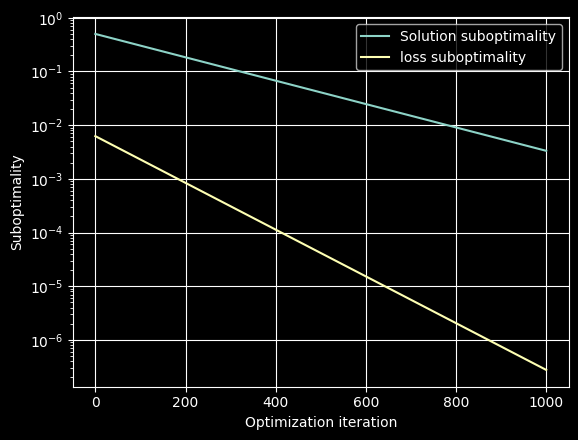

In [13]:
plt.plot(solution_suboptimality, label="Solution suboptimality")
plt.plot(loss_suboptimality, label="loss suboptimality")
plt.yscale("log")
plt.xlabel("Optimization iteration")
plt.ylabel("Suboptimality")
plt.legend()
plt.grid()

In [14]:
iterate_jacobian = jax.jacfwd(optimize_gd, argnums=0)(THETA)

In [15]:
iterate_jacobian.shape

(1001,)

In [16]:
exact_jacobian = jax.jacfwd(inner_objective_arg_optimum)(THETA)

In [17]:
jacobian_suboptimality = jnp.abs(
    iterate_jacobian - exact_jacobian
)

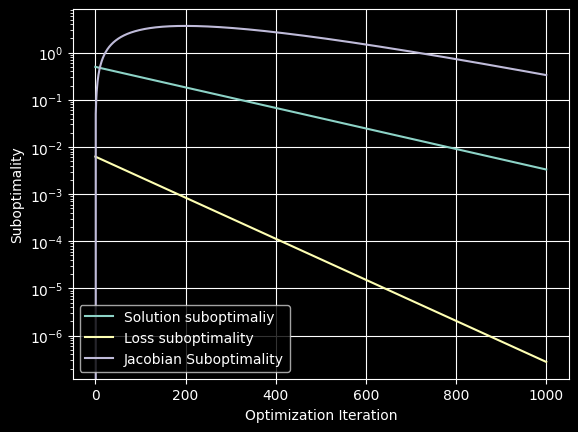

In [18]:
plt.plot(solution_suboptimality, label="Solution suboptimaliy")
plt.plot(loss_suboptimality, label="Loss suboptimality")
plt.plot(jacobian_suboptimality, label="Jacobian Suboptimality")
plt.yscale("log")
plt.legend()
plt.xlabel("Optimization Iteration")
plt.ylabel("Suboptimality")
plt.grid()

### Explaining the result

Here in our case the inner objective is

$$f(x, \theta) = \frac{1}{2}\theta x^2$$

As a consequence, the update rule for gradient descent is

$$\phi(x)=x - \eta\frac{\partial f}{\partial x} = x - \eta\theta x = (1 -\eta \theta) x$$

Evaluating this auto-regressively gives the recurrence

$$x^{[t]}=\phi^t(x^{[0]})=
(1 - \eta \theta)^tx^{[0]}$$

And for the Jacobian

$$\frac{\partial x^{[t]}}{\partial \theta}=-\eta t(1-\eta \theta)^{t-1}x^{[0]}$$

The analytical optimizer of our problem is easy

$$\frac{\partial f}{\partial x}=\theta x \overset{!}{=}0 \quad \iff
\quad x^*=0 \quad
\implies \frac{\partial x^*}{\partial \theta}=0$$

As such the Jacobian suboptimality is just

$$\left| \left|
\frac{\partial x^{[t]}}{\partial \theta} - \frac{\partial x^*}{\partial \theta}
\right| \right|
=
\left|
\eta t(1-\eta \theta)^{t-1}x^{[0]}
\right|$$

Plugging in our values, $\eta=0.1$, $\theta=0.05$ and $x^{[0]}=0.5$

$$\left| \left|
\frac{\partial x^{[t]}}{\partial \theta} - \frac{\partial x^*}{\partial \theta}
\right| \right|
=
\left|
0.05 t(0.995)^{t-1}
\right|$$

In [19]:
t_range = jnp.arange(1, 500)
linear_sequence = 0.05 * t_range
exponential_sequence = 0.995 ** (t_range - 1 )

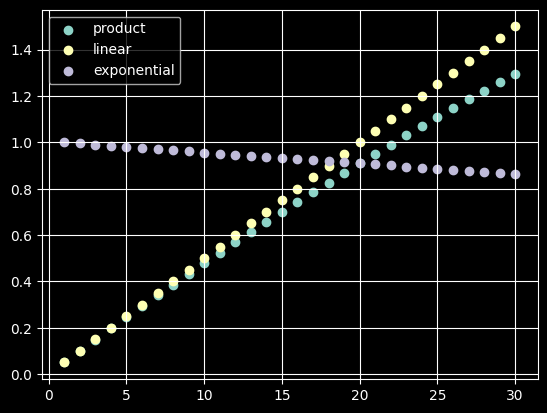

In [20]:
plt.scatter(t_range[:30], linear_sequence[:30]*exponential_sequence[:30], label="product")
plt.scatter(t_range[:30], linear_sequence[:30], label="linear")
plt.scatter(t_range[:30], exponential_sequence[:30], label="exponential")
plt.legend()
plt.grid()

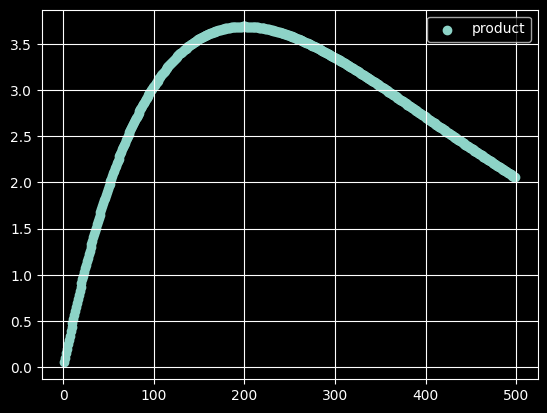

In [21]:
plt.scatter(t_range, linear_sequence * exponential_sequence, label="product")
plt.grid()
plt.legend()

As such the length of the burn-in period will be

$$t_{burn-in} ≈ \frac{1}{\kappa}$$

$\kappa$ here just is $\theta = 0.05$, hence $t_{burn-in} \approx 200$

Feel free to play around with the parameters:

- $\eta$: the learning rate
- $b$: the linear term in the objective
- $x_{init}$: the initial value for the optimization
- $\dots$

Ultimately, you will notice the "Curse of Unrolling"

![Screenshot from 2024-03-31 10-16-02.png](<attachment:Screenshot from 2024-03-31 10-16-02.png>)
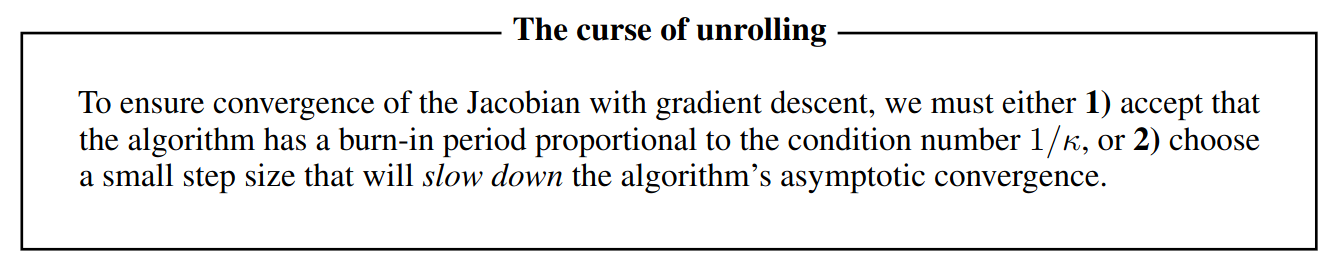